 - hash name
 - get python types from function type
 - add a compile function that takes (name, input types, output types) and returns a callable

In [1]:
from pathlib import Path

from xdsl.builder import ImplicitBuilder
from xdsl.dialects import arith, func, memref, scf
from xdsl.dialects.builtin import ArrayAttr, DictionaryAttr, FloatAttr, IndexType, IntegerAttr, ModuleOp, UnitAttr, f64, i64
from xdsl.ir import Block, Region

index = IndexType()

def get_module(n: int) -> ModuleOp:
    memref_t = memref.MemRefType(f64, [n])
    module = ModuleOp([])
    with ImplicitBuilder(module.body):
        f = func.FuncOp("hello", ((i64, i64), (i64,)))
        with ImplicitBuilder(f.body) as (lhs, rhs):
            res = arith.Addi(lhs, rhs).result
            func.Return(res)

        g = func.FuncOp("dist", ((memref_t, memref_t), (f64,)), arg_attrs=ArrayAttr((DictionaryAttr({"llvm.noalias": UnitAttr()}),) * 2))
        with ImplicitBuilder(g.body) as (lhs, rhs):
            zero = arith.Constant(IntegerAttr( 0, index)).result
            one = arith.Constant(IntegerAttr( 1, index)).result
            hundo = arith.Constant(IntegerAttr( n, index)).result

            initial = arith.Constant(FloatAttr(0.0, f64)).result

            body = Region(Block(arg_types=(index, f64)))
            norm_squared = scf.For(zero, hundo, one, (initial,), body)
            with ImplicitBuilder(norm_squared.body) as (i, acc):
                lhs_el = memref.Load.get(lhs, (i,)).res
                rhs_el = memref.Load.get(rhs, (i,)).res
                sq = arith.Mulf(lhs_el, rhs_el).result
                new_acc = arith.Addf(acc, sq)
                scf.Yield(new_acc)

            func.Return(norm_squared)

    return module

m = get_module(100)
m_str = str(m)

with open(Path() / "input.mlir", 'w') as f:
    f.write(m_str)

In [2]:
import ctypes

from xdsl.jit import jit_module

dbl_ptr_type = ctypes.POINTER(ctypes.c_double)

hey = jit_module(m, "hello", types=((int, int), int))
dist_mlir = jit_module(m, "dist", types=((dbl_ptr_type, dbl_ptr_type), float))
hey(5,6)

11

In [3]:
import numpy as np

In [4]:
n = 10000
a = np.random.random(n)
b = np.random.random(n)

In [5]:
a_data_ptr = a.ctypes.data_as(dbl_ptr_type)
b_data_ptr = b.ctypes.data_as(dbl_ptr_type)
%time dist_mlir(a_data_ptr, b_data_ptr)

CPU times: user 27 µs, sys: 71 µs, total: 98 µs
Wall time: 19.1 µs


23.494894028833343

In [6]:
%time hey(5, 6)

CPU times: user 5 µs, sys: 4 µs, total: 9 µs
Wall time: 8.82 µs


11

In [7]:
%time 1 + 2

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs


3

In [8]:
from typing import Any


def dist_np(lhs: np.ndarray[Any, np.dtype[np.float64]], rhs: np.ndarray[Any, np.dtype[np.float64]]) -> np.float64:
    return lhs.dot(rhs)

%time dist_np(a, b)

CPU times: user 17 µs, sys: 3 µs, total: 20 µs
Wall time: 21.9 µs


2499.5604988060345

In [9]:
def dist_python(lhs: np.ndarray[Any, np.dtype[np.float64]], rhs: np.ndarray[Any, np.dtype[np.float64]]) -> np.float64:
    res = np.float64(0.0)
    for l, r in zip(lhs, rhs):
        res += l * r
    return res

%time dist_python(a, b)

CPU times: user 2.27 ms, sys: 1.59 ms, total: 3.86 ms
Wall time: 936 µs


2499.5604988060354

In [10]:
import timeit

timeit.timeit(lambda: dist_python(a, b), number=100)

0.1969793748576194

In [11]:
import pandas as pd

In [12]:
from collections import defaultdict

In [13]:
res = defaultdict[str, list[float]](list)

powers = [int(10 ** i) for i in range(1, 6)]

for n in powers:
    a = np.random.random(n)
    b = np.random.random(n)
    dist_mlir_i = jit_module(get_module(n), "dist", types=((dbl_ptr_type, dbl_ptr_type), float))
    a_data_ptr = a.ctypes.data_as(dbl_ptr_type)
    b_data_ptr = b.ctypes.data_as(dbl_ptr_type)
    res["mlir"].append(timeit.timeit(lambda: dist_mlir_i(a_data_ptr, b_data_ptr), number=100))
    res["numpy"].append(timeit.timeit(lambda: dist_np(a, b), number=100))
    res["python"].append(timeit.timeit(lambda: dist_python(a, b), number=100))

res

defaultdict(list,
            {'mlir': [0.00029099988751113415,
              0.0003056658897548914,
              0.0006013750098645687,
              0.005781207932159305,
              0.05610308307223022],
             'numpy': [0.00012745801359415054,
              4.1082967072725296e-05,
              7.812492549419403e-05,
              0.0005139580462127924,
              0.004671167116612196],
             'python': [0.00014287489466369152,
              0.000989333027973771,
              0.008978083031252027,
              0.08850879198871553,
              0.9622767909895629]})

In [14]:
df = pd.DataFrame(res, index=powers)
df

,mlir,numpy,python
10,0.000291,0.000127,0.000143
100,0.000306,0.000041,0.000989
1000,0.000601,0.000078,0.008978
10000,0.005781,0.000514,0.088509
100000,0.056103,0.004671,0.962277


In [15]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


<Axes: ylabel='seconds'>

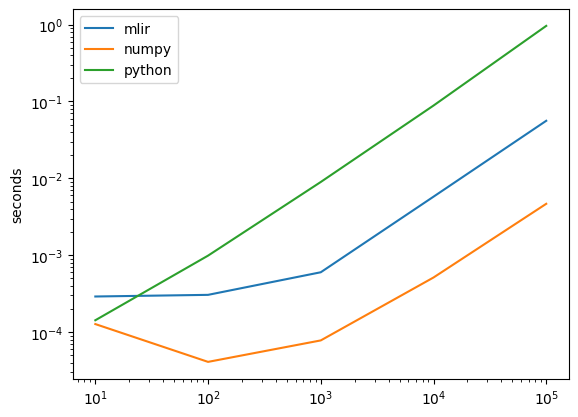

In [16]:
df.plot(logy=True, logx=True, ylabel="seconds")